# Validation Step 4 | End-to-End Data Analysis | Calibration Plots for the Validation Paper

Josh Dillon & the HERA Validation Team

September, 2020

## Introduction

This notebook contains code for plotting results that assess calibration in Validation Step 4, the end-to-end run of the H1C validation effort. It is designed to be run at NRAO. This notebook is meant for the purposes of reproducing these plots, rather than fully explaining them. See the Validation paper for more detail. For the code that ran this analysis, refer to [the pipeline repo](https://github.com/HERA-Team/hera_pipelines/tree/main/pipelines/validation/h1c_idr2_2) and especially [the configuration TOML](https://github.com/HERA-Team/hera_pipelines/blob/main/pipelines/validation/h1c_idr2_2/idr2_2_validation.toml). Further explaination of the equivalent real data products can be found in [this memo](http://reionization.org/manual_uploads/HERA069_IDR2.2_Memo_v3.html).

In [1]:
# This is where to save the results plots, modify if you want to re-run
plots_folder = '/users/jsdillon/lustre/Validation/Validation_Paper_Plots/'

## Software

In [2]:
import hera_cal
import uvtools
import numpy as np
import scipy
from scipy import stats
import matplotlib
from copy import deepcopy
import glob, os
import matplotlib.pyplot as plt
import uvtools
from tqdm.notebook import tqdm
from hera_cal import io, apply_cal, delay_filter, noise
from hera_cal import utils, redcal
from hera_cal.smooth_cal import CalibrationSmoother
from pyuvdata import UVData, UVCal, UVFlag
import pyuvdata

%matplotlib notebook

In [3]:
for module in [pyuvdata, hera_cal, uvtools, np, scipy, matplotlib]:
    if hasattr(module, 'version'):
        gh = getattr(module.version, 'git_hash', None)
    else:
        gh = None
    print("Module {:<11}....\tVersion {:<12}.......\tGit {}".format(module.__name__, module.__version__[:12], gh))

Module pyuvdata   ....	Version 2.1.2.dev23+.......	Git None
Module hera_cal   ....	Version 3.0         .......	Git 3e411d467fd6d425dda0ff48b4c5d6336a7c4fb7
Module uvtools    ....	Version 0.1.0       .......	Git 4070105863c362dd3c86ab0791590b10e3de6576
Module numpy      ....	Version 1.18.1      .......	Git None
Module scipy      ....	Version 1.4.1       .......	Git None
Module matplotlib ....	Version 3.1.3       .......	Git None


# Load True Gains and Recovered Gains

In [4]:
refant_num = 83 # this is an antenna that's unflagged for the entire data set
cmp = 'sum'
JDs = ['2458098', '2458099', '2458101', '2458102', '2458103', '2458106', '2458107', '2458108', '2458110', '2458111']

In [5]:
# Dictionaries to save the per-day results averaged over time and antenna
avg_relative_errors_true = {}
avg_phase_error_true = {}
avg_relative_amp_error_true = {}
avg_relative_errors_refl = {}
avg_phase_error_refl = {}
avg_relative_amp_error_refl = {}
avg_amplitude_ratio_smooth_over_true = {}
avg_amplitude_ratio_smooth_over_refl = {}

# Loop over days
for JD in tqdm(JDs):
    # Load the recovered gain solutions after smooth_cal
    cs_data = CalibrationSmoother(sorted(glob.glob(f'/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/{JD}_{cmp}/zen.*.{cmp}.corrupt.smooth_abs.calfits')))
    
    # Load simulated banpasses, with (cs_refl) and without (cs_true) refleciton systematics. 
    # Arguably, cs_refl is more "true" than cs_true, but that's a quirk of the naming scheme
    cs_true = CalibrationSmoother(sorted(glob.glob(f'/lustre/aoc/projects/hera/Validation/test-4.0.0/data/gains/{JD}.{cmp}.true_gains.calfits')))
    cs_refl = CalibrationSmoother(sorted(glob.glob(f'/lustre/aoc/projects/hera/Validation/test-4.0.0/data/gains/{JD}.{cmp}.reflections.calfits')))
    for ant in cs_refl.gain_grids:
        cs_refl.gain_grids[ant] *= cs_true.gain_grids[ant]
    
    # Terms to set the the reference antenna to match across
    true_rephasor = {jpol: np.abs(cs_true.gain_grids[(refant_num, jpol)]) / (cs_true.gain_grids[(refant_num, jpol)]) for jpol in ['Jee', 'Jnn']}
    refl_rephasor = {jpol: np.abs(cs_refl.gain_grids[(refant_num, jpol)]) / (cs_refl.gain_grids[(refant_num, jpol)]) for jpol in ['Jee', 'Jnn']}    
    smooth_rephasor = {jpol: np.abs(cs_data.gain_grids[(refant_num, jpol)]) / (cs_data.gain_grids[(refant_num, jpol)]) for jpol in ['Jee', 'Jnn']}

    # placeholders to save results for all antennas
    relative_errors_true = []
    rel_amp_errors_true = []
    phs_errors_true = []
    relative_errors_refl = []
    rel_amp_errors_refl = []
    phs_errors_refl = []
    amp_ratio_true = []
    amp_ratio_refl = []
    
    # loop over antennas
    for ant in tqdm(cs_data.gain_grids, leave=False):
        # Compute ampltiude ratios compared to cs_true
        amp_ratio = np.abs(cs_data.gain_grids[ant]) / np.abs(cs_true.gain_grids[ant])
        amp_ratio[cs_data.flag_grids[ant]] = np.nan
        amp_ratio_true.append(amp_ratio)
        
        # Compute ampltiude ratios compared to cs_reflt
        amp_ratio = np.abs(cs_data.gain_grids[ant]) / np.abs(cs_refl.gain_grids[ant])
        amp_ratio[cs_data.flag_grids[ant]] = np.nan
        amp_ratio_refl.append(amp_ratio)
        
        # Compute diffs relative to cs_true
        diff = cs_true.gain_grids[ant] * true_rephasor[ant[1]] - cs_data.gain_grids[ant] * smooth_rephasor[ant[1]]
        diff[cs_data.flag_grids[ant]] = np.nan
        relative_errors_true.append(np.abs(diff) / np.abs(cs_true.gain_grids[ant]))
        
        # Compute amplitudes of those diffs relative to cs_true
        amp_diff = np.abs(cs_true.gain_grids[ant]) - np.abs(cs_data.gain_grids[ant])
        amp_diff[cs_data.flag_grids[ant]] = np.nan
        rel_amp_errors_true.append(np.abs(amp_diff) / np.abs(cs_true.gain_grids[ant]))
        
        # Compute phases of those diffs relative to cs_true 
        phs_diff = np.angle(cs_true.gain_grids[ant] * true_rephasor[ant[1]]) - np.angle(cs_data.gain_grids[ant] * smooth_rephasor[ant[1]])
        phs_diff[cs_data.flag_grids[ant]] = np.nan
        phs_diff = np.abs(phs_diff)
        # Handle phase jumps appropriately
        phs_diff[phs_diff > np.pi] = np.abs(2*np.pi - phs_diff[phs_diff > np.pi])
        phs_errors_true.append(phs_diff)
        
        # Compute diffs relative to cs_refl
        diff = cs_refl.gain_grids[ant] * refl_rephasor[ant[1]] - cs_data.gain_grids[ant] * smooth_rephasor[ant[1]]
        diff[cs_data.flag_grids[ant]] = np.nan
        relative_errors_refl.append(np.abs(diff) / np.abs(cs_refl.gain_grids[ant]))
        
        # Compute amplitudes of those diffs relative to cs_refl
        amp_diff = np.abs(cs_refl.gain_grids[ant]) - np.abs(cs_data.gain_grids[ant])
        amp_diff[cs_data.flag_grids[ant]] = np.nan
        rel_amp_errors_refl.append(np.abs(amp_diff) / np.abs(cs_refl.gain_grids[ant]))
        
        # Compute phases of those diffs relative to cs_refl
        phs_diff = np.angle(cs_refl.gain_grids[ant] * refl_rephasor[ant[1]]) - np.angle(cs_data.gain_grids[ant] * smooth_rephasor[ant[1]])
        phs_diff[cs_data.flag_grids[ant]] = np.nan
        phs_diff = np.abs(phs_diff)
        # Handle phase jumps appropriately        
        phs_diff[phs_diff > np.pi] = np.abs(2*np.pi - phs_diff[phs_diff > np.pi])
        phs_errors_refl.append(phs_diff)        
    
    # average up all diffs/errors over unflagged antennas and times
    avg_relative_errors_true[JD] = np.nanmean(relative_errors_true, axis=(0,1))
    avg_relative_amp_error_true[JD] = np.nanmean(rel_amp_errors_true, axis=(0,1))
    avg_phase_error_true[JD] = np.nanmean(phs_errors_true, axis=(0,1))

    avg_relative_errors_refl[JD] = np.nanmean(relative_errors_refl, axis=(0,1))
    avg_relative_amp_error_refl[JD] = np.nanmean(rel_amp_errors_refl, axis=(0,1))
    avg_phase_error_refl[JD] = np.nanmean(phs_errors_refl, axis=(0,1))
    
    avg_amplitude_ratio_smooth_over_true[JD] = np.nanmean(amp_ratio_true, axis=(0,1))
    avg_amplitude_ratio_smooth_over_refl[JD] = np.nanmean(amp_ratio_refl, axis=(0,1))

invalid value encountered in greater
invalid value encountered in greater
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice


# Plot Comparison of True and Recovered Gain Solutions

<IPython.core.display.Javascript object>


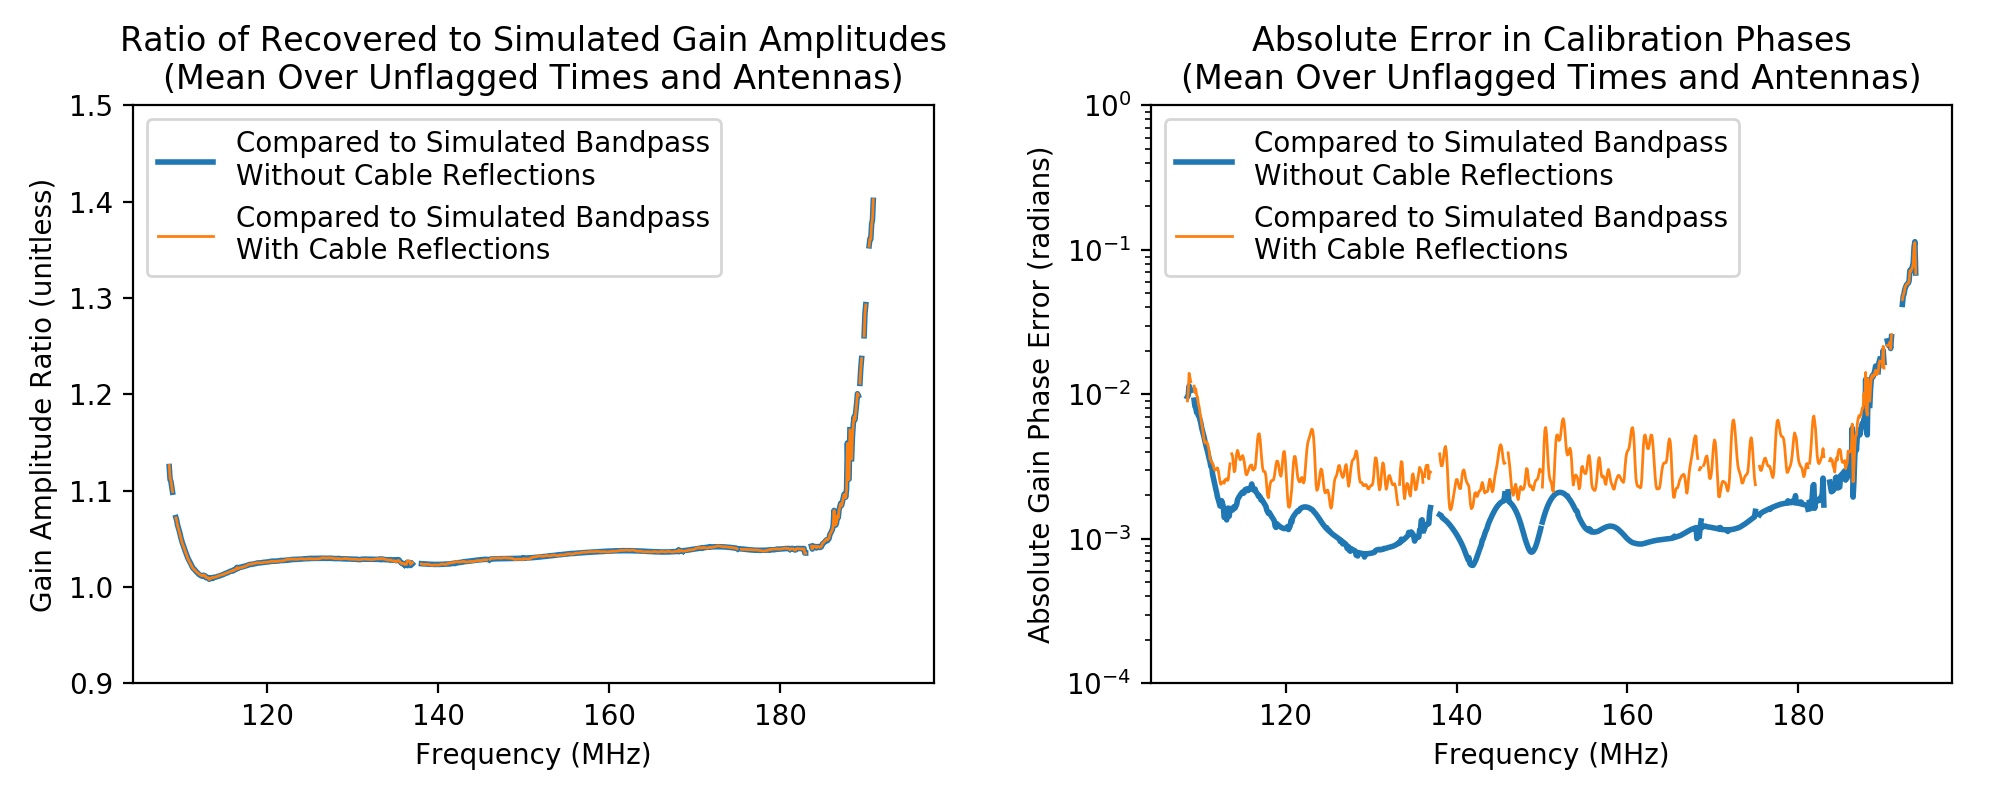

Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice


In [6]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(cs_true.freqs/1e6, np.nanmean(list(avg_amplitude_ratio_smooth_over_true.values()), axis=0),
           lw=2, label='Compared to Simulated Bandpass\nWithout Cable Reflections')
ax[0].plot(cs_true.freqs/1e6, np.nanmean(list(avg_amplitude_ratio_smooth_over_refl.values()), axis=0),
           lw=1, label='Compared to Simulated Bandpass\nWith Cable Reflections')

ax[0].set_title('Ratio of Recovered to Simulated Gain Amplitudes\n(Mean Over Unflagged Times and Antennas)')
ax[0].set_ylabel('Gain Amplitude Ratio (unitless)')
ax[0].set_xlabel('Frequency (MHz)')
ax[0].legend()
ax[0].set_ylim([.9,1.5])

ax[1].semilogy(cs_true.freqs/1e6, np.nanmean(list(avg_phase_error_true.values()), axis=0),
               lw=2, label='Compared to Simulated Bandpass\nWithout Cable Reflections')
ax[1].semilogy(cs_true.freqs/1e6, np.nanmean(list(avg_phase_error_refl.values()), axis=0),
               lw=1, label='Compared to Simulated Bandpass\nWith Cable Reflections')
    
    
ax[1].set_ylabel('Absolute Gain Phase Error (radians)')
ax[1].set_xlabel('Frequency (MHz)')
ax[1].set_title('Absolute Error in Calibration Phases\n(Mean Over Unflagged Times and Antennas)')
ax[1].set_ylim([1e-4, 1])
ax[1].legend()

plt.tight_layout()
plt.savefig(plots_folder + 'smooth_cal_errors.pdf')

**Figure 1** | Comparison of true and recovered gain solutions. See Validation paper for a full caption.

# Plot the $\chi^2$ of Redundant Baseline Calibration Compared to the Theoretical Expectation

In [7]:
cmp = 'sum'
hd_true = io.HERAData('/lustre/aoc/projects/hera/Validation/test-4.0.0/data/visibilities/2458098/zen.2458098.43124.sum.true.uvh5')

# dictionaries to acculumate results for each day
all_chisqs = {}
all_DoF = {}
all_1D_chisq = {}

# loop over days
for JD in tqdm(JDs):
    cs_red = CalibrationSmoother(sorted(glob.glob(f'/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/{JD}_{cmp}/zen.*.{cmp}.corrupt.omni.calfits')), load_chisq=True)
    
    # check that flags are sensible
    flagged_ants = [ant for ant in cs_red.flag_grids if np.all(cs_red.flag_grids[ant])]
    assert np.all(((np.sum(np.all(np.array(list(cs_red.flag_grids.values())), axis=(2)), axis=0)) == len(flagged_ants)) + \
                  ((np.sum(np.all(np.array(list(cs_red.flag_grids.values())), axis=(2)), axis=0)) == len(cs_red.flag_grids)))

    # compute degrees of freedom in redcal, see https://arxiv.org/abs/2003.08399
    for pol in ['ee', 'nn']:
        reds = redcal.get_reds(hd_true.antpos, pols=[pol])
        reds = redcal.filter_reds(reds, ex_ants=flagged_ants)
        reds = redcal.filter_reds(reds, antpos=hd_true.antpos, min_bl_cut=15., max_bl_cut=90.)
        nUbls = len(reds)
        nObs = np.sum([len(red) for red in reds])
        nAnts = len(set([ant for red in reds for bl in red for ant in utils.split_bl(bl)]))
        DoF = nObs - (nAnts + nUbls - 2)
        print(f'On {JD} polarization {pol} DoF = {DoF}: {nUbls} unique baselines, {nObs} total baselines, {nAnts} unflagged antennas')
        
    all_DoF[JD] = DoF
    all_chisqs[JD] = cs_red.chisq_grids
    
    # pick out unflagged chi^2 and collapse to 1D along time, freq, and pol for histograming
    flags = cs_red.flag_grids[[ant for ant in cs_red.flag_grids if ant not in flagged_ants][0]]
    chisqs = cs_red.chisq_grids['Jee'][~flags]
    chisqs = np.append(chisqs, cs_red.chisq_grids['Jnn'][~flags])
    all_1D_chisq[JD] = chisqs

Telescope RIMEz calculation is not in known_telescopes.


On 2458098 polarization ee DoF = 164: 49 unique baselines, 235 total baselines, 24 unflagged antennas
On 2458098 polarization nn DoF = 164: 49 unique baselines, 235 total baselines, 24 unflagged antennas
On 2458099 polarization ee DoF = 164: 49 unique baselines, 235 total baselines, 24 unflagged antennas
On 2458099 polarization nn DoF = 164: 49 unique baselines, 235 total baselines, 24 unflagged antennas
On 2458101 polarization ee DoF = 164: 49 unique baselines, 235 total baselines, 24 unflagged antennas
On 2458101 polarization nn DoF = 164: 49 unique baselines, 235 total baselines, 24 unflagged antennas
On 2458102 polarization ee DoF = 164: 49 unique baselines, 235 total baselines, 24 unflagged antennas
On 2458102 polarization nn DoF = 164: 49 unique baselines, 235 total baselines, 24 unflagged antennas
On 2458103 polarization ee DoF = 164: 49 unique baselines, 235 total baselines, 24 unflagged antennas
On 2458103 polarization nn DoF = 164: 49 unique baselines, 235 total baselines, 24

The above printout should show that all days have the same number of DoF, meaning that they can be histogrammed together and compared to the same theoretical $\chi^2$-distribution. If the number of unflagged antennas changed, then DoF may have changed, but that was not the case in this data set.

<IPython.core.display.Javascript object>


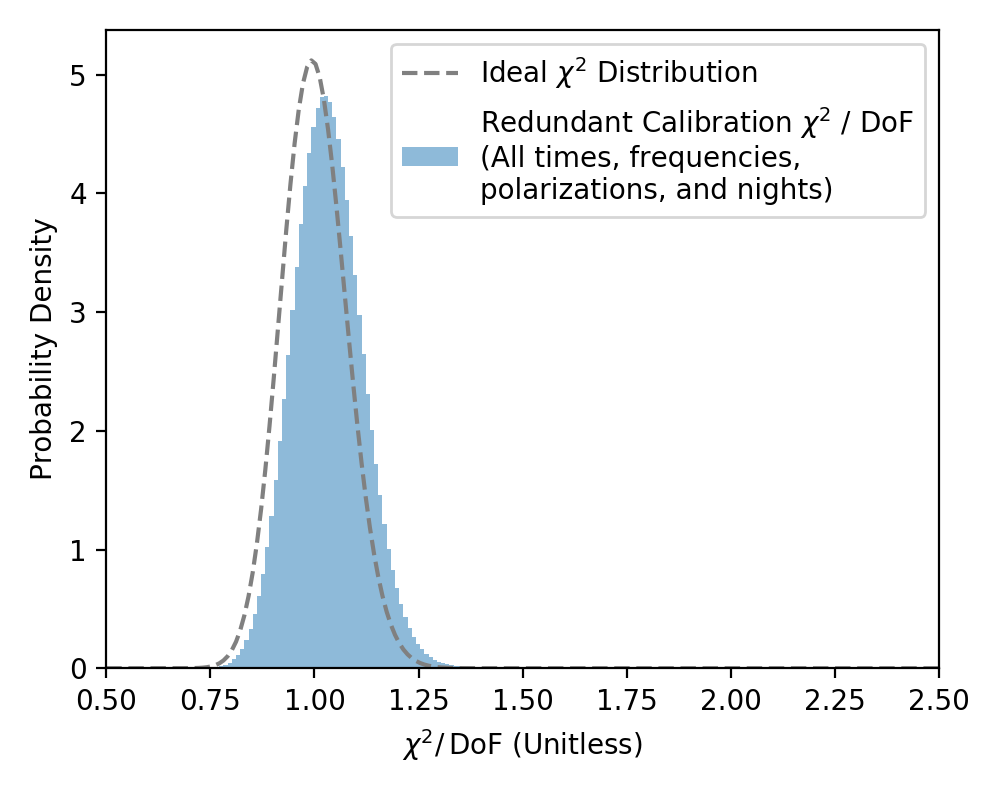

In [8]:
plt.figure(figsize=(5,4))
x = np.linspace(.5,2.5,200)
plt.hist(np.hstack(list(all_1D_chisq.values())), x, density=True, alpha=.5, 
         label='Redundant Calibration $\chi^2$ / DoF\n(All times, frequencies,\npolarizations, and nights)')
k = DoF * 2
plt.plot(x, stats.chi2.pdf(x*k, k)*k, '--', label="Ideal $\chi^2$ Distribution".format(k), c='grey')
plt.xlabel('$\chi^2/\,$DoF (Unitless)')
plt.ylabel('Probability Density')
plt.legend()
plt.xlim([np.min(x), np.max(x)])
plt.tight_layout()
plt.savefig(plots_folder + 'chisq_distribution.pdf')

**Figure 2** | Comparison of ideal and recovered redundant calibration calibration $\chi^2$ / DoF. The difference is due to per-baseline systematics (e.g. cross-talk). See Validation paper for a full caption.

# Plot Array Configuration and Antenna Flags

Telescope RIMEz calculation is not in known_telescopes.


<IPython.core.display.Javascript object>


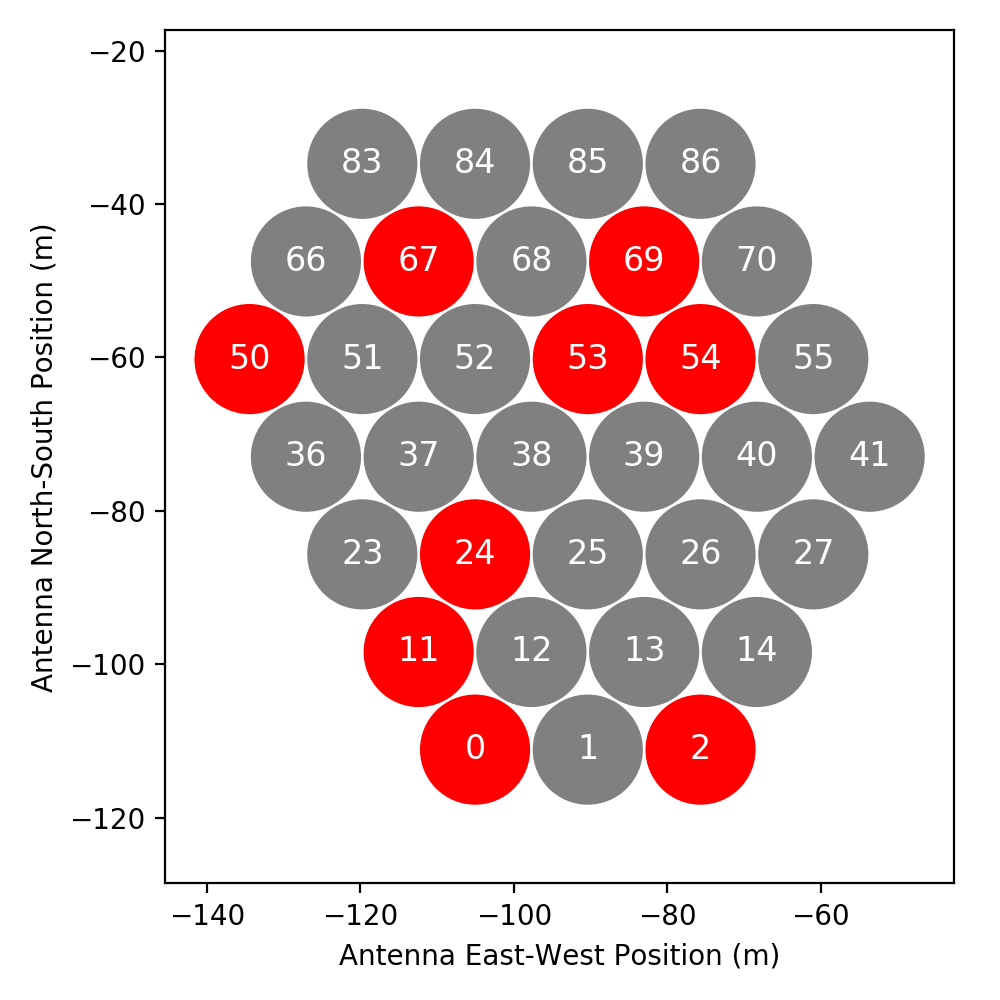

In [9]:
hd = io.HERAData('/lustre/aoc/projects/hera/Validation/test-4.0.0/data/visibilities/2458098/zen.2458098.43124.sum.true.uvh5')
ex_ants = set([ant[0] for ant in cs_red.flag_grids if np.all(cs_red.flag_grids[ant])])
plt.figure(figsize=(5,5))
plt.scatter(np.array(list(hd.antpos.values()))[:,0], 
            np.array(list(hd.antpos.values()))[:,1], c='w', s=0)
for ant,pos in hd.antpos.items():
    bad = ant in ex_ants
    plt.gca().add_artist(plt.Circle(tuple(pos[0:2]), radius=7, 
                                    fill=(~bad), color=['grey','r'][bad]))
    plt.text(pos[0],pos[1],str(ant), size=12, va='center', ha='center', color='w')
plt.xlabel("Antenna East-West Position (m)")
plt.ylabel("Antenna North-South Position (m)")
plt.axis('equal')
plt.xlim([-150,-38])

plt.tight_layout()
plt.savefig(plots_folder + 'antenna_positions_and_flags.pdf')

**Figure 3** | Array configuration used with antenna flags indicated in red. See Validation paper for a full caption.

# Plot Abscal Amplitude Bias Waterfalls For a Single Night, 2458098

In [10]:
refant_num = 83
cmp = 'sum'
JD = '2458098' 

In [11]:
# Again, load true simulated calibration solutions (reflections have unit amplitude and can be ignored)
cs_true = CalibrationSmoother(sorted(glob.glob(f'/lustre/aoc/projects/hera/Validation/test-4.0.0/data/gains/{JD}.{cmp}.true_gains.calfits')))

# Load absolute calibration gain solutions, both before and after smoothing (rephase is irrelevant for investigating amplitudes)
cs_abs = CalibrationSmoother(sorted(glob.glob(f'/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/{JD}_{cmp}/zen.*.{cmp}.corrupt.abs.calfits')))
cs_smooth = CalibrationSmoother(sorted(glob.glob(f'/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/{JD}_{cmp}/zen.*.{cmp}.corrupt.smooth_abs.calfits')))    

# Compute ampliutde ratio waterfall for abscal
abs_ratios = []
for ant in cs_abs.gain_grids:
    ratio = np.abs(cs_abs.gain_grids[ant]) / np.abs(cs_true.gain_grids[ant])
    ratio[cs_abs.flag_grids[ant]] = np.nan
    abs_ratios.append(ratio)
abs_ratio = np.nanmean(abs_ratios, axis=0)

# Compute ampliutde ratio waterfall for smooth_cal
smooth_ratios = []
for ant in cs_smooth.gain_grids:
    ratio = np.abs(cs_smooth.gain_grids[ant]) / np.abs(cs_true.gain_grids[ant])
    ratio[cs_abs.flag_grids[ant]] = np.nan
    smooth_ratios.append(ratio)
smooth_ratio = np.nanmean(smooth_ratios, axis=0)

Mean of empty slice
Mean of empty slice


<IPython.core.display.Javascript object>


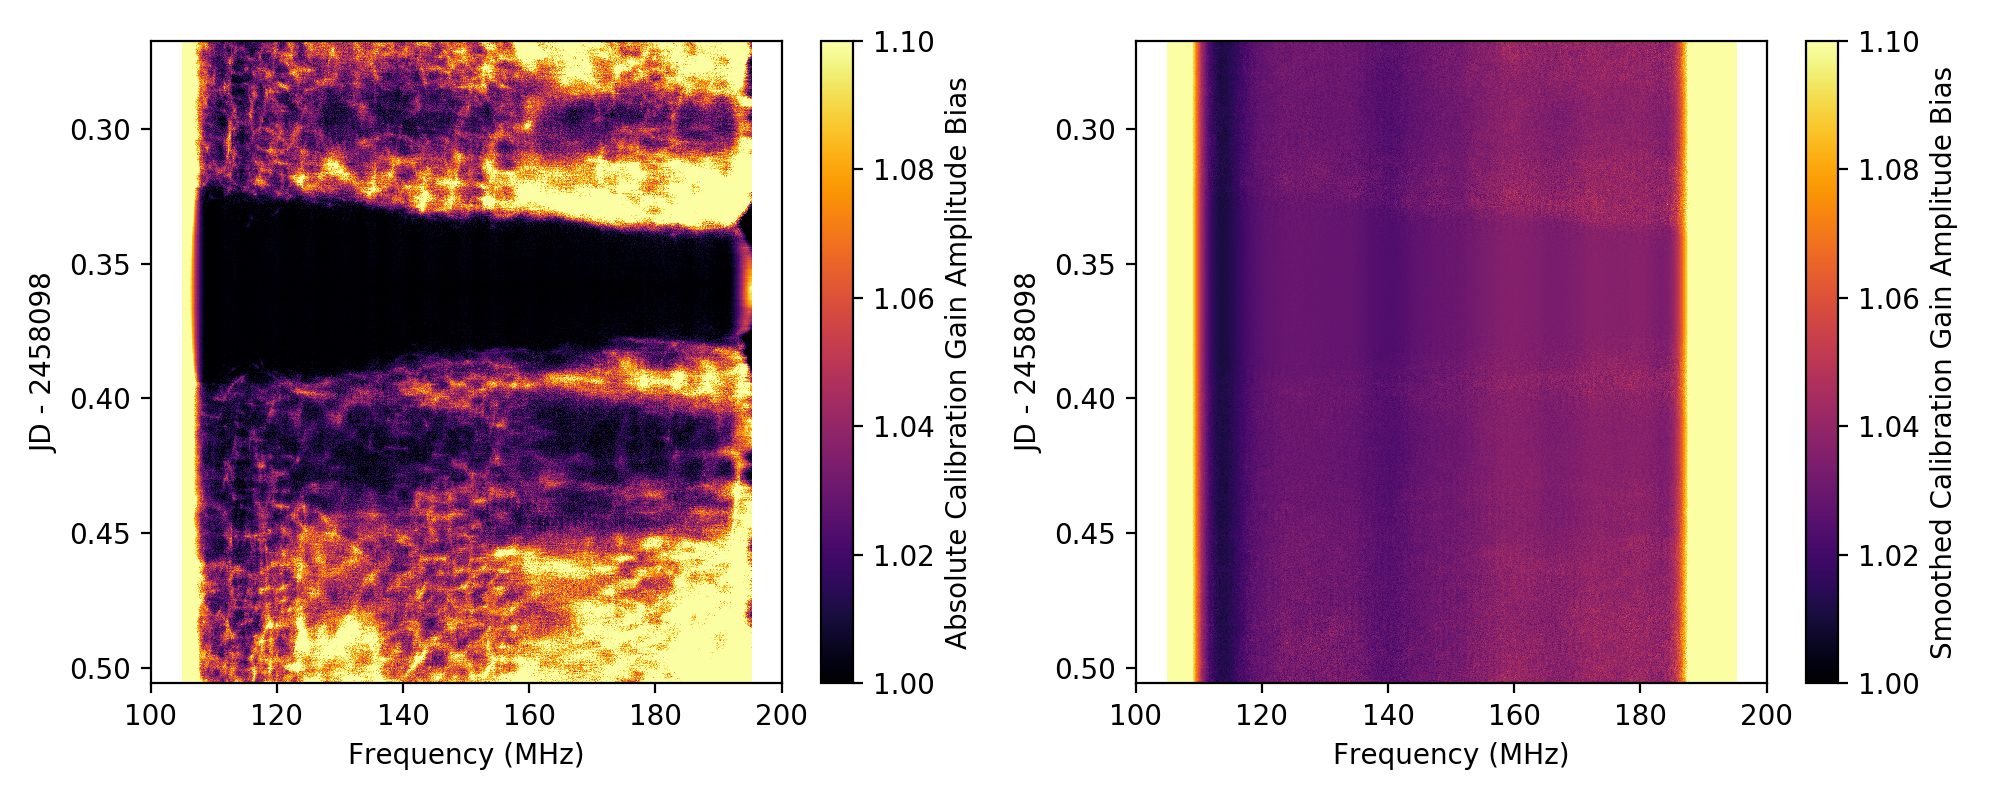

In [12]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(abs_ratio, aspect='auto', cmap='inferno',
           extent=[cs_abs.freqs[0]/1e6, cs_abs.freqs[-1]/1e6, cs_abs.time_grid[-1]-2458098, cs_abs.time_grid[0]-2458098])
plt.clim([1,1.1])
plt.colorbar(label='Absolute Calibration Gain Amplitude Bias')
plt.xlabel('Frequency (MHz)')
plt.ylabel('JD - 2458098')

plt.subplot(122)
plt.imshow(smooth_ratio, aspect='auto', cmap='inferno',
           extent=[cs_abs.freqs[0]/1e6, cs_abs.freqs[-1]/1e6, cs_abs.time_grid[-1]-2458098, cs_abs.time_grid[0]-2458098])
plt.clim([1,1.1])
plt.colorbar(label='Smoothed Calibration Gain Amplitude Bias')
plt.xlabel('Frequency (MHz)')
plt.ylabel('JD - 2458098')

plt.tight_layout()
plt.savefig(plots_folder + 'abscal_bias.pdf')

**Figure 4** | Bias in absolute calibration amplitude, both before and after calibration smoothing. This effect is [better explained here](https://github.com/HERA-Team/hera_cal/issues/642), and [being fixed for future analysis here](https://github.com/HERA-Team/hera_cal/pull/647). See Validation paper for a full caption.

# Plot metrics assessing noise in LST-binned data on a single file, `LST.1.69139`

In [13]:
# Load LST-binned visibilities, and the standard deviation over nights of those LST-binned visibilities
hd = io.HERAData('/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.LST.1.69139.HH.OCRSL.uvh5')
data, flags, nsamples = hd.read()
hd_std = io.HERAData('/lustre/aoc/projects/hera/Validation/test-4.0.0/pipeline/LSTBIN/sum/zen.grp1.of1.STD.1.69139.HH.OCRSL.uvh5')
data_std, flags_std, nsamples_std = hd_std.read()

antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.


In [14]:
# Get the integration time of the original data
hd_true = io.HERAData('/lustre/aoc/projects/hera/Validation/test-4.0.0/data/visibilities/2458098/zen.2458098.43124.sum.true.uvh5')
tint = np.median(np.diff(hd_true.times)) * 24 * 3600

Telescope RIMEz calculation is not in known_telescopes.


In [15]:
# lists to store estimates of the nosie variance in the LST-binned data products
all_obs_var = []
all_predicted_var = []
all_interleaved_var = []
all_predicted_binned_var = []

# Loop over baselines
for bl in tqdm(data.bls()):
    ant1, ant2 = utils.split_bl(bl)
    auto1 = utils.join_bl(ant1, ant1)
    auto2 = utils.join_bl(ant2, ant2)    
    if auto1 == auto2:
        continue # ignore autocorrelations in assessing noise
    
    # Flag integrations with fewer than 10 samples
    flags_here = deepcopy(flags[bl])
    flags_here |= flags[auto1] | flags[auto2]
    flags_here |= (nsamples[bl] < 10)

    # Predicted night-to-night visibility variance
    predicted_var = noise.predict_noise_variance_from_autos(bl, data, dt=tint)
    predicted_var[flags_here] = np.nan
    all_predicted_var.append(predicted_var)
    
    # Observed night-to-night visibiltiy variance
    obs_var = deepcopy(data_std[bl])**2
    obs_var[flags_here] = np.nan
    obs_nsamples = deepcopy(nsamples_std[bl])
    obs_nsamples[flags_here] = np.nan
    obs_var *= (obs_nsamples / (obs_nsamples - 1))
    all_obs_var.append(obs_var)

    # Predicted visibiltiy variance after LST-binning
    predicted_binned_var = noise.predict_noise_variance_from_autos(bl, data, dt=tint, nsamples=nsamples)
    predicted_binned_var[flags_here] = np.nan
    all_predicted_binned_var.append(predicted_binned_var)    
    
    # Observed visibiltiy variance after LST-binning
    data_here = deepcopy(data[bl])
    data_here[flags_here] = np.nan
    interleaved_variance = noise.interleaved_noise_variance_estimate(data_here, kernel=[[-.5,1,-.5]])
    all_interleaved_var.append(interleaved_variance)
    

divide by zero encountered in true_divide


In [16]:
# average all visibiltiy variances over times and unflagged antennas
mean_obs_var = np.nanmean(np.abs(all_obs_var), axis=(0,1))
mean_predicted_var = np.nanmean(all_predicted_var, axis=(0,1))
mean_interleaved_var = np.nanmean(np.abs(all_interleaved_var), axis=(0,1))
mean_predicted_binned_var = np.nanmean(all_predicted_binned_var, axis=(0,1))

Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice


<IPython.core.display.Javascript object>


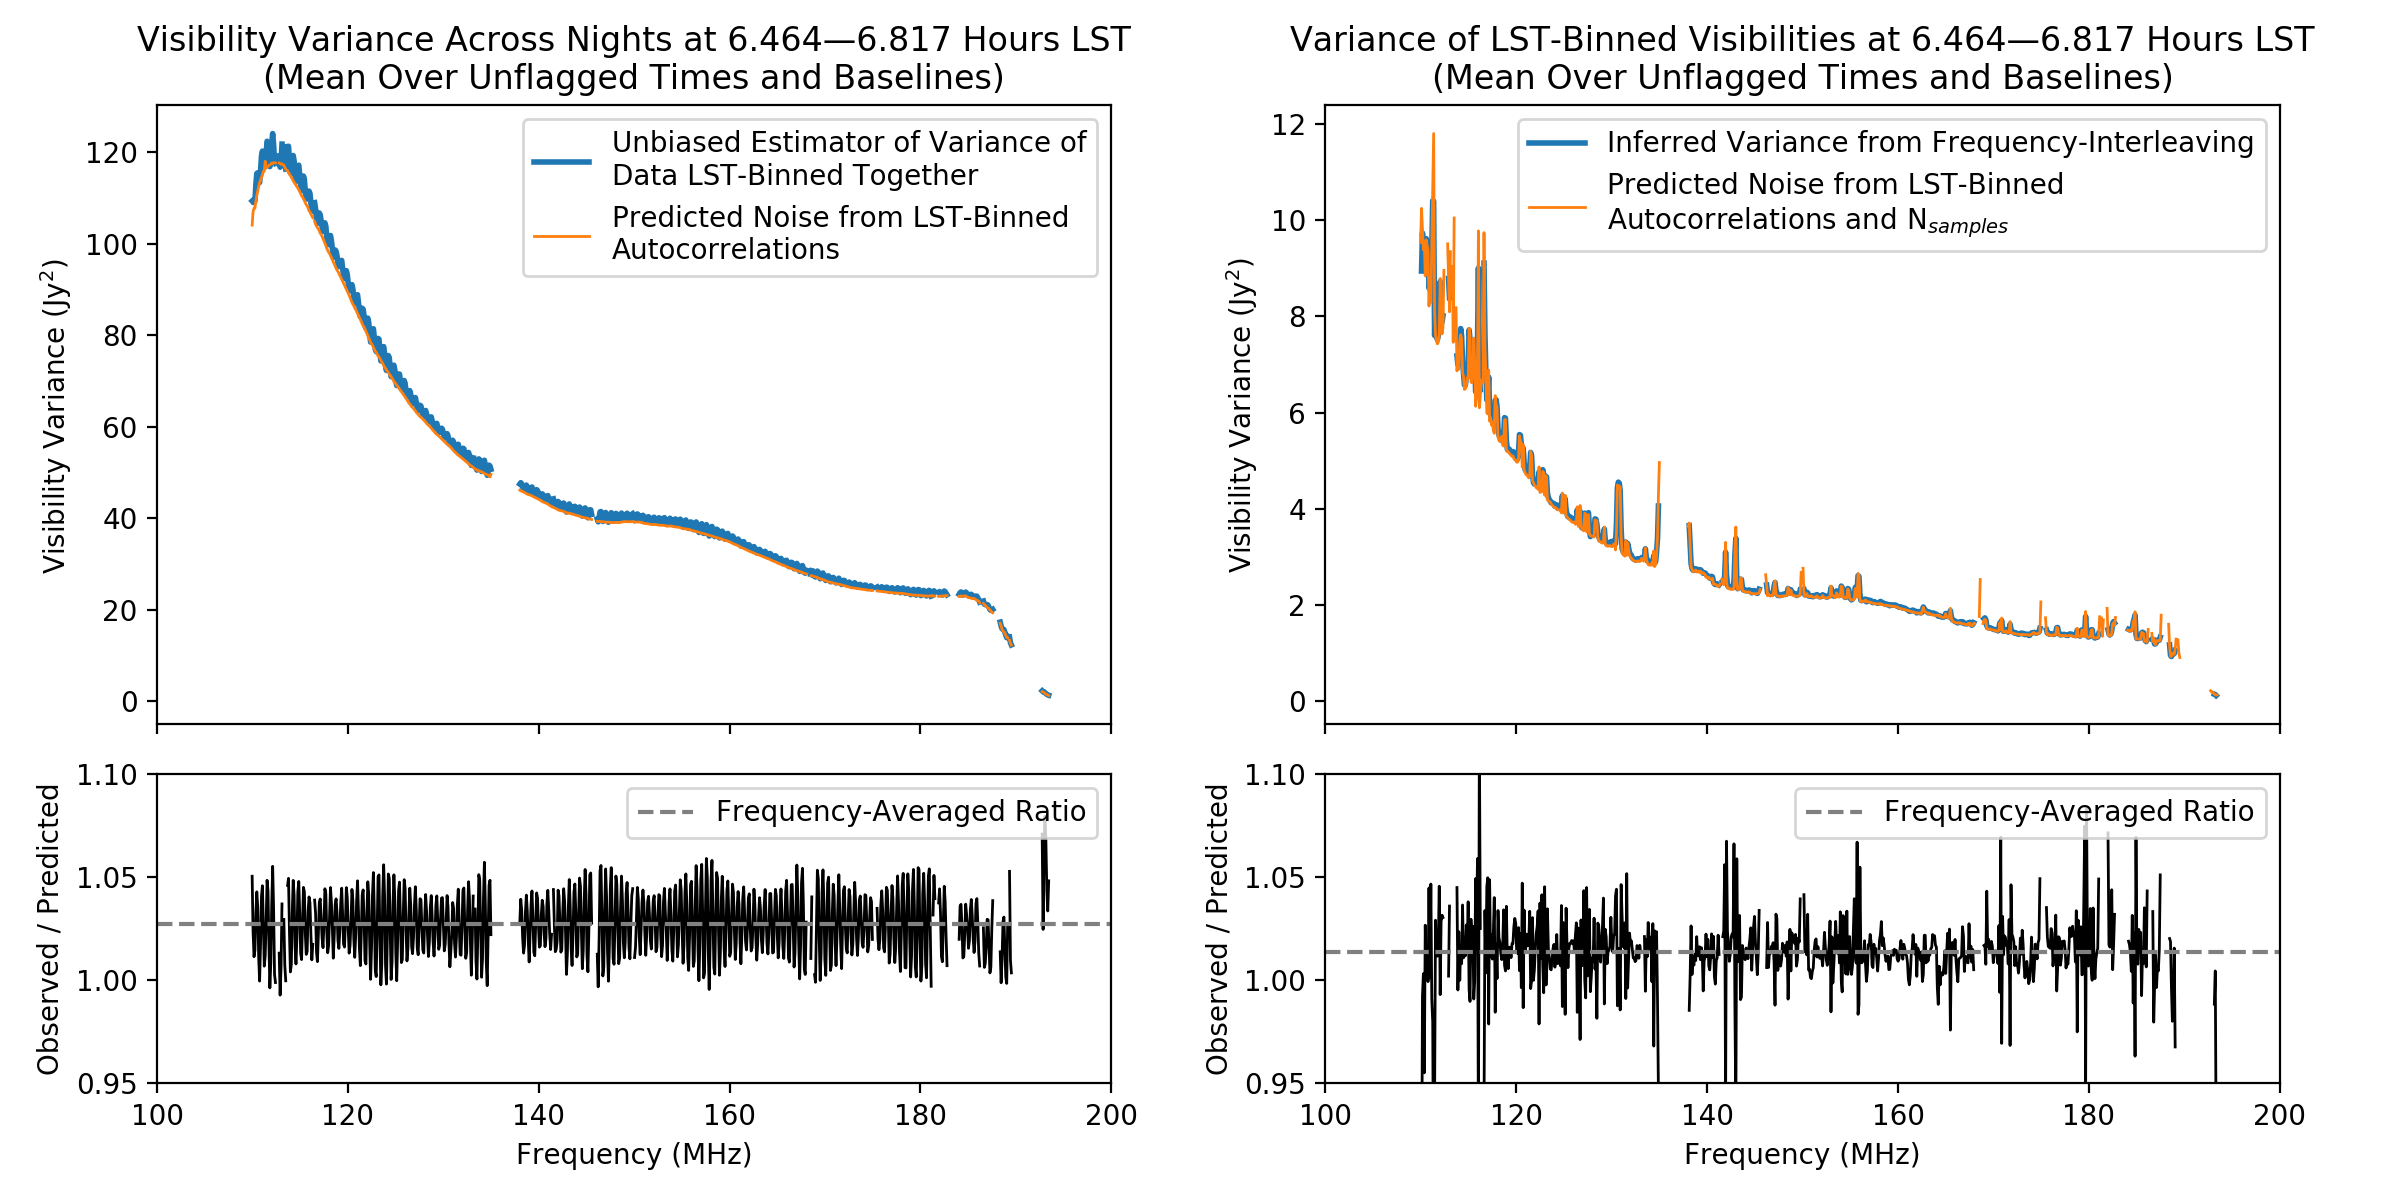

In [17]:
# plot results
fig, ax = plt.subplots(2,2, figsize=(12,6), sharex='col', gridspec_kw={'height_ratios': [2, 1]})
plt.subplots_adjust(hspace=.0)
ax=ax.flatten()

ax[0].plot(hd_true.freqs/1e6, mean_obs_var, lw=2, label='Unbiased Estimator of Variance of\nData LST-Binned Together')
ax[0].plot(hd_true.freqs/1e6, mean_predicted_var, lw=1, label='Predicted Noise from LST-Binned\nAutocorrelations')
ax[0].set_ylabel('Visibility Variance (Jy$^2$) ')
ax[0].set_title(f'Visibility Variance Across Nights at {np.round(hd.lsts[0]*12/np.pi,3)}—{np.round(hd.lsts[-1]*12/np.pi,3)} Hours LST'
                '\n(Mean Over Unflagged Times and Baselines)')
ax[0].legend()

ax[1].plot(hd_true.freqs/1e6, mean_interleaved_var, lw=2, label='Inferred Variance from Frequency-Interleaving')
ax[1].plot(hd_true.freqs/1e6, mean_predicted_binned_var, lw=1, label='Predicted Noise from LST-Binned\nAutocorrelations and N$_{samples}$')
ax[1].set_ylabel('Visibility Variance (Jy$^2$)')
ax[1].set_title(f'Variance of LST-Binned Visibilities at {np.round(hd.lsts[0]*12/np.pi,3)}—{np.round(hd.lsts[-1]*12/np.pi,3)} Hours LST'
                '\n(Mean Over Unflagged Times and Baselines)')
ax[1].legend()

ax[2].plot(hd_true.freqs/1e6, mean_obs_var/mean_predicted_var, 'k-', lw=1)
ax[2].plot(hd_true.freqs/1e6, np.ones_like(hd_true.freqs) * np.nanmean(mean_obs_var/mean_predicted_var), '--', c='grey', label='Frequency-Averaged Ratio')
ax[2].set_xlabel('Frequency (MHz)')
ax[2].set_xlim([100,200])
ax[2].set_ylim([.95, 1.1])
ax[2].set_ylabel('Observed / Predicted')
ax[2].legend(loc='upper right')

ax[3].plot(hd_true.freqs/1e6, mean_interleaved_var/mean_predicted_binned_var, 'k-', lw=1)
ax[3].plot(hd_true.freqs/1e6, np.ones_like(hd_true.freqs) * np.nanmean(mean_interleaved_var/mean_predicted_binned_var), '--', c='grey', label='Frequency-Averaged Ratio')
ax[3].set_xlabel('Frequency (MHz)')
ax[3].set_ylim([.95, 1.1])
ax[3].set_xlim([100,200])
ax[3].set_ylabel('Observed / Predicted')
ax[3].legend(loc='upper right')

plt.tight_layout()
plt.savefig(plots_folder + 'lst_binning_visibility_variance.pdf')

**Figure 5** | Two comparisons of noise in LST-binned results. Left compares the variance across nights to what's expected from the LST-binned autocorrelations. Right compares the inferred variance from frequency-interleaving to the prediction from those autos and the number of samples. See Validation paper for a full caption.